# Imports

In [83]:
import glob
import os
import pandas as pd 
import numpy as np 
import regex as re 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import datetime as dt
import tensorflow as tf
import warnings
from sklearn.preprocessing import MinMaxScaler 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
warnings.filterwarnings('ignore')
from matplotlib.dates import DateFormatter

# Load data

In [84]:
df = pd.read_csv('./new_final.csv')

# Define dataset

In [85]:
df.head()

,Month,Sun_Hours,HPI,Unemployment_Rate,Total_Crimes
0,2017-01,2.1,118.06,4.6,144
1,2017-02,2.0,118.34,4.6,166
2,2017-03,3.8,118.02,4.5,194
3,2017-04,6.0,119.10,4.4,169
4,2017-05,6.3,119.38,4.4,169


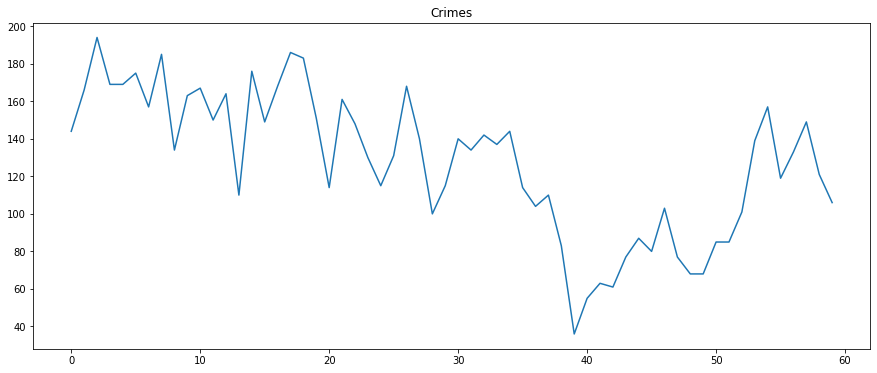

In [86]:
df.Total_Crimes.plot(figsize=(15,6),title='Crimes')
plt.gcf().set_facecolor('white');

# Create train and test sets and perform MinMax scaling 

In [87]:
# make the dataset easily formattable 
df.Month = pd.to_datetime(df.Month)
scaler = MinMaxScaler()

train_data = df[df.Month.dt.year <= 2020].iloc[:,-1].dropna()
test_data = df[df.Month.dt.year==2021].iloc[:,-1]

train_data = scaler.fit_transform(train_data.values.reshape(-1,1)).reshape(-1)
test_data = scaler.fit_transform(test_data.values.reshape(-1,1)).reshape(-1)

### Function to create windowed periods of data and shuffle for nonuniformity

In [88]:
def sampling(sequence, n_steps):

    X, Y = list(), list()

    for i in range(len(sequence)):

        sam = i + n_steps
        if sam > len(sequence)-1:
            break

        x, y = sequence[i:sam], sequence[sam]

        X.append(x)

        Y.append(y)

    return np.array(X), np.array(Y)

In [89]:
n_steps = 3


X_train, y_train = sampling(train_data.tolist(), n_steps)
X_test, y_test = sampling(test_data.tolist(), n_steps)

n_features = len(X_train)

#### Preview of the training data
Essentially, the format of the data is [2017 Jan, 2017 Feb, 2017 Mar] as X values and the corresponding Y value is 2017 April. And the next row is [2017 May,Jun, July] and the corresponding Y value is 2017 August. \
**The values below are scaled values of the original crime data.**

In [90]:
for i in range(5):
    print(X_train[i],y_train[i])

[0.6835443  0.82278481 1.        ] 0.8417721518987341
[0.82278481 1.         0.84177215] 0.8417721518987341
[1.         0.84177215 0.84177215] 0.8797468354430379
[0.84177215 0.84177215 0.87974684] 0.7658227848101266
[0.84177215 0.87974684 0.76582278] 0.9430379746835443


# Model

In [91]:
# create any cache and set seed to obtain uniform results
tf.keras.backend.clear_session()
tf.random.set_seed(51)

# build the model
bidirectional = tf.keras.models.Sequential([

        # transform dataset to correct dimensions
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),  
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
        ])

input_shape=(None,)
bidirectional.build(input_shape)
bidirectional.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-traina

# Training process

In [92]:
def train_model(model, epochs=100, verbose=False, label=str):
    # automatically updates the optimizer learning rate every epoch
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
                lambda epoch: 1e-8 * 10**(epoch/20))

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8)
    model.compile(loss=tf.keras.losses.Huber(),
                optimizer=optimizer,
                metrics=['mae'])

    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), callbacks=[lr_schedule], verbose=verbose)
    
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'],color='blue')
    plt.title('{} Model: Loss per Epoch'.format(label),weight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history.history['val_loss'], color='orange')
    plt.legend(['Train Loss','Test Loss'])

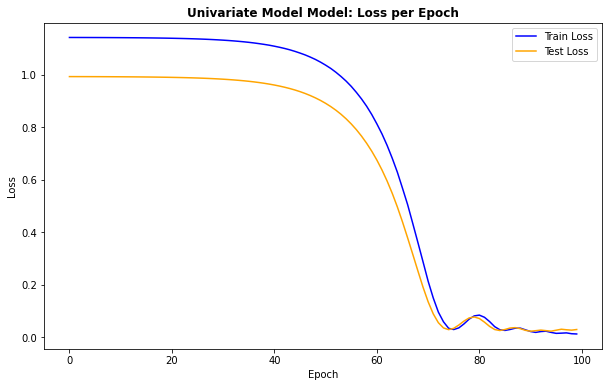

In [93]:
train_model(bidirectional, label='Univariate Model')

# Evaluation metrics

### Mean Absolute Error
#### On shuffled test dataset, it is evident that the model performs well as the MAE < 0.3

In [94]:
# define metrics functions
def mean_squared_error(y_true, y_pred):
    return np.mean(np.square(y_pred - y_true))

def rmse(y_true, y_pred):
	return np.sqrt(mean_squared_error(y_pred,y_true))

In [95]:
bidirectional.evaluate(X_test, y_test)

1/1 [==============================] - 0s 20ms/step - loss: 0.0297 - mae: 0.2072


[0.029709313064813614, 0.2071978896856308]

### Evaluating with 2021 data

In [96]:
def plot_predictions(model, label=str):
    
    y_true = scaler.inverse_transform(y_test.reshape(-1,1))
    y_hat = scaler.inverse_transform(model.predict(X_test))

    # plot the true and predicted values
    plt.figure(figsize=(10,6))
    plt.title('{} Model Predictions'.format(label),weight='bold',size=14)
    plt.xlabel('Index of Values')
    plt.ylabel('Number of crimes')
    plt.plot(y_true,label='True Values')
    plt.plot(y_hat,label='Predicted Values')
    plt.legend(loc='best')
    plt.gcf().set_facecolor('white');

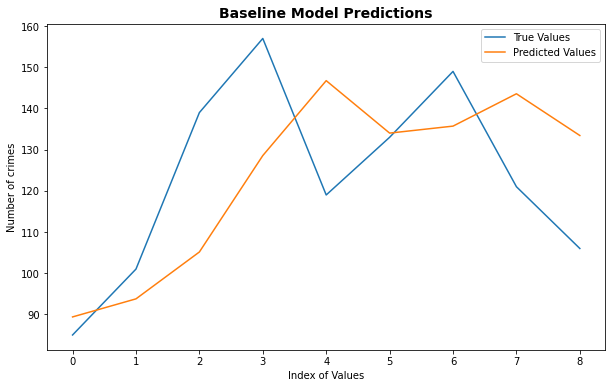

In [97]:
plot_predictions(bidirectional,label='Baseline')